# from .out file to a plot of mutation directions

put full path to single_locus_trajectories.out file, full path to reference .dat file, desired coverage cutoff, and desired minimum variant frequency below

In [71]:
variant_path = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/Single_locus_trajectories10.out"

ref_dat_path = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/ref/Reading_Frames.dat"

"/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/ref/Reading_Frames.dat"

In [72]:
# read variants file into a dataframe
using DataFrames

# Define the function to read the .out file
function read_out_file(filepath::String)
    # Initialize an empty DataFrame
    df = DataFrame(pos = Int[], original_base = String[], variant_base = String[])
    
    # Open the file and process each line
    open(filepath, "r") do file
        for line in eachline(file)
            # Remove any leading/trailing whitespace
            stripped_line = strip(line)
            
            # Continue only if the line is not empty
            if !isempty(stripped_line)
                # Split the line into parts, typically space-delimited
                parts = split(stripped_line)
                
                # Ensure there are enough parts to avoid index errors
                if length(parts) < 3
                    continue  # Skip this line if it doesn't have enough parts
                end

                # Extract the position, original base, and variant base
                pos = parse(Int, parts[1])
                original_base = parts[2]  # Should be a single character string
                variant_base = parts[3]   # Should be a single character string
                
                # Append to the DataFrame
                push!(df, (pos, original_base, variant_base))
            end
        end
    end
    
    return df
end

variants = read_out_file(variant_path)

using CategoricalArrays

function call_muts(df::DataFrame)
    # Check if the required columns are present in the DataFrame
    if !("original_base" in names(df) && "variant_base" in names(df))
        error("DataFrame must contain 'original_base' and 'variant_base' columns")
    end

    # Create a new column 'mutation' by concatenating 'original_base', '->', 'variant_base'
    mutations = df.original_base .* "->" .* df.variant_base

    # Define the order of categories
    levels_order = ["A->C", "A->G", "A->T", "C->A", "C->G", "C->T", "G->A", "G->C", "G->T", "T->A", "T->C", "T->G"]

    # Convert 'mutations' into a categorical array with predefined levels
    df.mutation = categorical(mutations, ordered=true, levels=levels_order)
    
    return df
end

variants = call_muts(variants)

Row,pos,original_base,variant_base,mutation
,Int64,String,String,Cat…
1,11,A,G,A->G
2,18,A,G,A->G
3,141,G,A,G->A
4,144,G,T,G->T
5,380,T,C,T->C
6,576,G,A,G->A
7,754,A,G,A->G
8,811,C,T,C->T
9,977,C,A,C->A


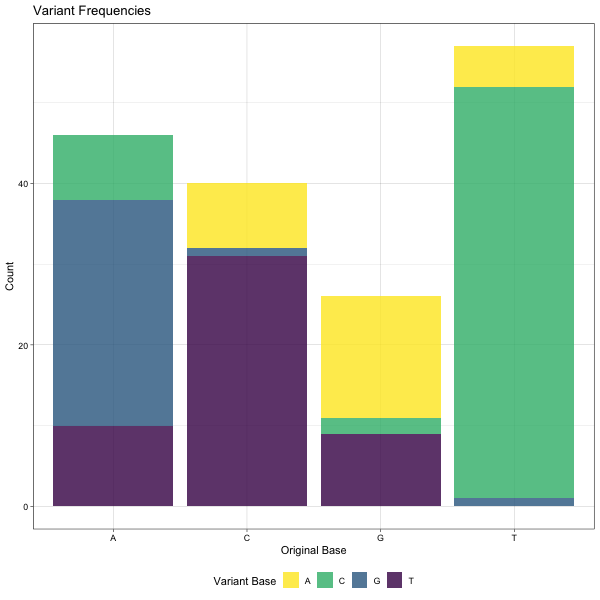

Temporary file deleted successfully.


In [73]:
# barplot of mutation frequencies
using RCall
using FileIO  # To handle image files in Julia
using Images  # Ensure you have this package

@rput variants  # Send the DataFrame to R environment

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

# Create the ggplot in R and save it as a PNG file
R"""
library(ggplot2)
library(viridis)
p <- ggplot(variants, aes(x = original_base, fill = variant_base)) +
  geom_bar(stat = "count") +
  theme_linedraw() +
  theme(legend.position = "bottom") +
  labs(title = "Variant Frequencies", x = "Original Base", y = "Count", fill = "Variant Base") +
  scale_fill_viridis(discrete = TRUE, alpha = 0.8, direction = -1)

png(filename = $output_path, width = 600, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
    img = load(output_path)
    display(img)

    # Delete the temporary image file after displaying
    rm(output_path; force = true)
    println("Temporary file deleted successfully.")
else
    println("File does not exist.")
end


In [74]:
# pull two .fas from .dat file 
using RCall

# Function to handle the .dat file processing
function pull_frames(dat_file_path::String)
    # Define the paths for the .fa files in Julia before calling R
    nucleotide_fasta_path = replace(dat_file_path, ".dat" => "_nucleotide.fa")
    aa_fasta_path = replace(dat_file_path, ".dat" => "_amino_acid.fa")

    # Pass the file paths to R
    @rput dat_file_path
    @rput nucleotide_fasta_path
    @rput aa_fasta_path
    
    # Ensure that Biostrings and other required libraries are available in R
    R"""
    if (!requireNamespace("Biostrings", quietly = TRUE)) {
        if (!requireNamespace("BiocManager", quietly = TRUE))
            install.packages("BiocManager")
        BiocManager::install("Biostrings")
    }
    """

    R"""
    library(Biostrings)
    library(stringr)
    process_file <- function(dat_file_path, fasta_nucleotide_path, fasta_amino_acid_path) {
        lines <- tryCatch({
            readLines(dat_file_path)
        }, error = function(e) {
            cat("Error reading file:", e$message, "\n")
            return(NULL)  # Return NULL to handle error gracefully
        })
        if (is.null(lines)) return()  # Exit if file could not be read

        con_nuc <- file(fasta_nucleotide_path, open = "w")
        con_aa <- file(fasta_amino_acid_path, open = "w")
        
        for (i in seq(1, length(lines), by = 3)) {
            if (i + 2 > length(lines)) {
                break
            }
            header <- strsplit(lines[i], " ")[[1]]
            if (length(header) < 3) {
                next
            }
            start_pos <- header[1]
            end_pos <- header[2]
            annotation <- paste(header[3:length(header)], collapse=" ")
            full_annotation <- paste0('"accession":', start_pos, '..', end_pos, ' | ', annotation)
            dna_seq <- DNAString(lines[i+1])
            aa_seq <- AAString(lines[i+2])
            
            writeLines(paste0(">", full_annotation), con_nuc)
            writeLines(as.character(dna_seq), con_nuc)
            writeLines(paste0(">", full_annotation), con_aa)
            writeLines(as.character(aa_seq), con_aa)
        }
        
        close(con_nuc)
        close(con_aa)
    }
    """
    # Call the R function from Julia with paths
    R"process_file($(dat_file_path), $(nucleotide_fasta_path), $(aa_fasta_path))"
    
    # Julia prints and retains the paths in variables
    println("nucleotide .fa : ", nucleotide_fasta_path)
    println("amino acid .fa : ", aa_fasta_path)

    return nucleotide_fasta_path, aa_fasta_path
end


nucleotide_fasta_path, aa_fasta_path = pull_frames(ref_dat_path)

nucleotide .fa : /Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/ref/Reading_Frames_nucleotide.fa
amino acid .fa : /Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/ref/Reading_Frames_amino_acid.fa


("/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/ref/Reading_Frames_nucleotide.fa", "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/ref/Reading_Frames_amino_acid.fa")

In [75]:
using DataFrames
using RCall

# Ensure that Biostrings and other required libraries are available in R
R"""
if (!requireNamespace("Biostrings", quietly = TRUE)) {
    if (!requireNamespace("BiocManager", quietly = TRUE))
        install.packages("BiocManager")
    BiocManager::install("Biostrings")
}
"""

function pull_fasta(fasta_path::String)
    # Read the fasta file using Biostrings in R
    R"""
    library(Biostrings)
    library(stringr)
    dna_seqs <- readDNAStringSet($(fasta_path))
    headers <- names(dna_seqs)
    
    # Parse headers to extract Accession, Start, End, and Protein
    accession <- str_extract(headers, "^[^:]+")
    range <- str_extract(headers, "\\d+\\.\\.\\d+")
    start <- as.integer(sub("\\.\\..*$", "", range))
    end <- as.integer(sub("^.*\\.\\.", "", range))
    protein <- str_extract(headers, "\\|\\s*(.*)$")
    protein <- str_trim(str_sub(protein, str_locate(protein, "\\|")[[1]] + 1)) # Trim pipe and whitespace
    """

    # Convert R data to Julia DataFrame
    accessions = rcopy(R"accession")
    starts = rcopy(R"start")
    ends = rcopy(R"end")
    proteins = rcopy(R"protein")
    sequences = rcopy(R"sapply(dna_seqs, as.character)")

    # Create a DataFrame from the extracted data
    fasta_df = DataFrame(
        Protein = proteins,
        Start = starts,
        End = ends,
        Sequence = sequences
    )

    return fasta_df
end

fasta_df = pull_fasta(nucleotide_fasta_path)

Row,Protein,Start,End,Sequence
,String,Int64,Int64,String
1,NS1,77,496,ATGGGCAGCAACTCATTGAGTATGATAAAAGTTAGATTGCAAAATCTGTTTGACAATGATGAAGTAGCATTGTTAAAAATAACATGTTATACTGACAAATTAATACAGTTAACTAATGCTTTGGCTAAGGCAGTTATACATACAATCAAATTGAATGGCATTGTATTTGTGCATGTTATTACAAGTAGTGATATTTGCCCTAATAATAATATTGTAGTGAAATCCAATTTCACAACAATGCCAGTATTACAAAATGGAGGTTATATATGGGAAATGATGGAATTAACACACTGCTCTCAACCTAATGGCCTAATAGATGACAATTGTGAAATTAAATTCTCCAAAAAACTAAGTGATTCAACAATGACCAATTATATGAATCAATTATCTGAATTACTTGGATTTGACCTCAATCCATAA
2,NS2,606,980,ATGGACACAACACACAATGATACCACACCACAAAGACTGATGATCACAGACATGAGACCATTATCGCTTGAAACTATAATAACATCTCTAACCAGAGACATCATAACACATAAATTTATATACTTGATAAATCATGAATGCATAGTGAGAAAACTTGATGAAAGACAGGCCACATTTACATTTCTGGTCAACTATGAAATGAAACTATTGCACAAAGTGGGAAGCACTAAATATAAAAAATATACTGAATACAACACAAAATATGGCACTTTCCCTATGCCAATATTTATCAATCATGATGGGTTCTTAGAATGCATTGGCATTAAGCCCACCAAGCACACACCCATAATATACAAGTACGATCTCAATCCATGA
3,N (Nucleoprotein),1094,2293,ATGAAAGATGGGGCAAATACAAAAATGGCTCTTAGCAAAGTCAAGTTGAATGATACACTCAACAAAGATCAACTTCTATCATCCAGCAAATATACCATCCAACGGAGCACAGGAGACAGCATTGACACTCCTAATTATGATGTGCAGAAACACATTAATAAGTTATGTGGCATGTTATTAATCACAGAAGATGCTAATCACAAATTCACTGGGTTAATAGGTATGTTATATGCTATGTCTAGATTAGGAAGAGAAGACACCATAAAAATACTCAAAGATGCGGGATATCATGTTAAGGCAAATGGAGTGGATGTAACAACACATCGTCAAGACATTAATGGGAAAGAAATGAAATTTGAAGTGTTAACATTAGCAAGCTTAACAACTGAAATTCAAATCAACATTGAGATAGAATCTAGAAAATCCTACAAAAAAATGCTAAAAGAAATGGGAGAGGTGGCTCCAGAATACAGGCATGACTCTCCTGATTGTGGGATGATAATATTATGTATAGCAGCATTAGTAATAACCAAATTAGCAGCAGGAGATAGATCAGGTCTTACAGCTGTGATTAGGAGAGCTAACAATGTTCTAAAAAATGAAATGAAACGTTATAAAGGTTTATTACCCAAGGATATAGCCAACAGCTTCTATGAAGTGTTTGAAAAATATCCTCACTTTATAGATGTTTTTGTTCATTTTGGTATAGCACAATCTTCTACCAGAGGTGGCAGTAGAGTTGAAGGGATTTTCGCAGGATTGTTTATGAATGCCTATGGTGCAGGGCAAGTGATGTTACGGTGGGGGGTCTTAGCAAAATCAGTTAAAAACATTATGTTAGGACACGCTAGTGTACAAGCAGAAATGGAACAAGTTGTGGAGGTGTATGAGTATGCTCAGAAATTGGGTGGAGAAGCAGGATTCTACCATATATTGAACAACCCAAAGGCATCACTATTATCTTTGACTCAATTTCCTCACTTCTCTAGTGTAGTATTGGGCAATGCTGCTGGCCTAGGCATAATGGGAGAATACAGAGGTACACCAAGGAATCAAGATTTATATGATGCTGCAAAAGCATATGCTGAACAACTCAAAGAAAATGGTGTGATTAACTACAGTGTATTAGATTTGACAGCAGAAGAACTAGAGGCTATCAAACATCAGCTTAATCCAAAAGATAATGATGTAGAGCTTTGA
4,P (Phosphoprotein),2325,3050,ATGGAAAAGTTTGCTCCTGAATTCCATGGAGAAGATGCAAACAACAGAGCCACCAAATTCCTAGAATCAATAAAGGGCAAATTCACATCACCCAAAGATCCCAAGAAAAAAGATAGTATCATATCTGTCAACTCAATAGATATAGAAGTAACCAAAGAAAGCCCTATAACATCAAACTCAACCACTATAAACCCAATAAATGAGACAGATGATACTGTAGGGAACAAGCCCAATTATCAAAGAAAGCCTCTAGTAAGTTTCAAAGAAGACCCTACGCCAAGTGATAATCCTTTTTCAAAACTATACAAAGAAACCATAGAAACATTTGATAACAATGAAGAAGAGTCTAGCTATTCATATGAAGAAATAAATGATCAGACAAACGATAATATAACAGCAAGATTAGATAGGATTGATGAGAAATTAAGTGAAATACTAGGAATGCTTCACACATTAGTAGTAGCGAGTGCAGGACCCACATCTGCTCGGGATGGTATAAGAGATGCCATGGTTGGTTTAAGAGAAGAAATGATAGAAAAAATCAGAACTGAAGCATTAATGACCAATGACAGACTAGAAGCTATGGCAAGACTCAGGAATGAAGAAAGTGAAAAGATGGCAAAAGACACATCAGATGAAGTGTCTCTCAATCCAACATCAGAGAAACTGAACAACCTGTTGGAAGGGAATGATAGTGACAATGATCTATCACTTGAAGATTTCTGA
5,Matrix,3233,4003,ATGGAAACATACGTGAATAAACTTCACGAAGGCTCCACATACACAGCTGCTGTTCAATACAATGTCCTAGAAAAAGACGATGATCCTGCATCACTTACAATATGGGTGCCCATGTTCCAATCATCCATGCCAGCAGATCTACTCATAAAAGAACTAGCCAATGTCAATATACTAGTGAAACAAATATCCACACCCAAGGGACCCTCATTAAGAGTCATGATAAACTCAAGAAGTGCAGTGCTAGCACAAATGCCCAGCAAATTTACCATATGTGCCAATGTGTCCTTGGATGAAAGAAGCAAGCTGGCATATGATGTAACCACACCCTGTGAAATTAAGGCATGCAGTCTAACATGCCTAAAATCAAAAAATATGTTAACTACAGTTAAAGATCTCACTATGAAAACACTCAACCCAACACATGACATCATTGCTTTATGTGAATTTGAAAATATAGTAACATCAAAAAAAGTCATAATACCAACATACCTAAGATCTATCAGCGTCAGAAATAAAGATCTGAACACACTCGAAAATATAACAACCACTGAATTCAAAAATGCCATTACAAATGCAAAAATCATCCCTTACTCAGGACTACTGTTAGTCATCACAGTGACTGACAACAAAGGAGCATTCAAATACATAAAGCCACAAAGTCAATTCATAGTAGATCTTGGAGCTTACCTAGAAAAAGAAAGTATATATTATGTCACAACAAATTGGAAGCACACAGCTACACGATTTGCAATCAAACCCATGGAAGATTAA
6,SH protein,4273,4467,ATGGAAAATACATCCATAACTATAGAATTCTCAAGCAAATTCTGGCCTTACTTTACACTAATACACATGATAACAACAATAATCTCTTTGATAATCATAATCTCCATCATGATTGCAATACTAAACAAACTCTGCGAATATAATGTATTCCATAACAAAACCTTTGAGCTACCAAGAGCTCGAGTCAATACATAG
7,G Glycoprotein,4659,5624,ATGTCCAAAACCAAGGACCAACGCACCGCCAAGACACTAGAAAGGACCTGGGACACTCTCAATCATCTATTATTCATATCATCGTGCTTATA

In [76]:
# match proteins by position 

using DataFrames

function call_proteins(variants_df::DataFrame, fasta_df::DataFrame)
    # Initialize an empty DataFrame for results, pre-defining the columns by combining both DataFrame's columns
    cols = names(variants_df)
    append!(cols, names(fasta_df))
    result_df = DataFrame(; [Symbol(col) => Any[] for col in cols]...)

    # Iterate over each row in variants_df
    for variant in eachrow(variants_df)
        pos = variant[:pos]  # Accessing the 'pos' column in variants_df

        # Filter fasta_df to find rows where 'pos' is between 'Start' and 'End'
        matches = filter(row -> row[:Start] <= pos <= row[:End], fasta_df)

        # For each match, concatenate the row from variants_df with the row from fasta_df
        for match in eachrow(matches)
            # Create a new row by extracting the data from both variant and match
            new_row = [variant[coln] for coln in names(variants_df)]
            append!(new_row, [match[coln] for coln in names(fasta_df)])
            push!(result_df, new_row)
        end
    end

    return result_df
end

variants = call_proteins(variants, fasta_df)

# retype columns
using CategoricalArrays
# Convert 'pos' to Int64 if it's not already an integer
variants.pos = variants.pos isa AbstractArray{Int} ? variants.pos : parse.(Int, string.(variants.pos))

# Convert 'original_base', 'variant_base', 'mutation', and 'Sequence' to String
variants.original_base = string.(variants.original_base)
variants.variant_base = string.(variants.variant_base)
variants.mutation = string.(variants.mutation)
variants.Sequence = string.(variants.Sequence)

# Convert 'Protein' to categorical
variants.Protein = categorical(variants.Protein)

# Convert 'Start' and 'End' to Int64 if they're not already integers
variants.Start = variants.Start isa AbstractArray{Int} ? variants.Start : parse.(Int, string.(variants.Start))
variants.End = variants.End isa AbstractArray{Int} ? variants.End : parse.(Int, string.(variants.End))

# Print the modified dataframe
println(variants)


147×8 DataFrame
 Row │ pos    original_base  variant_base  mutation  Protein             Start  End    Sequence                          
     │ Int64  String         String        String    Cat…                Int64  Int64  String                            
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │   141  G              A             G->A      NS1                    77    496  ATGGGCAGCAACTCATTGAGTATGATAAAAGT…
   2 │   144  G              T             G->T      NS1                    77    496  ATGGGCAGCAACTCATTGAGTATGATAAAAGT…
   3 │   380  T              C             T->C      NS1                    77    496  ATGGGCAGCAACTCATTGAGTATGATAAAAGT…
   4 │   754  A              G             A->G      NS2                   606    980  ATGGACACAACACACAATGATACCACACCACA…
   5 │   811  C              T             C->T      NS2                   606    980  ATGGACACAACACACAATGATACCACACCACA…
   6 │   977 

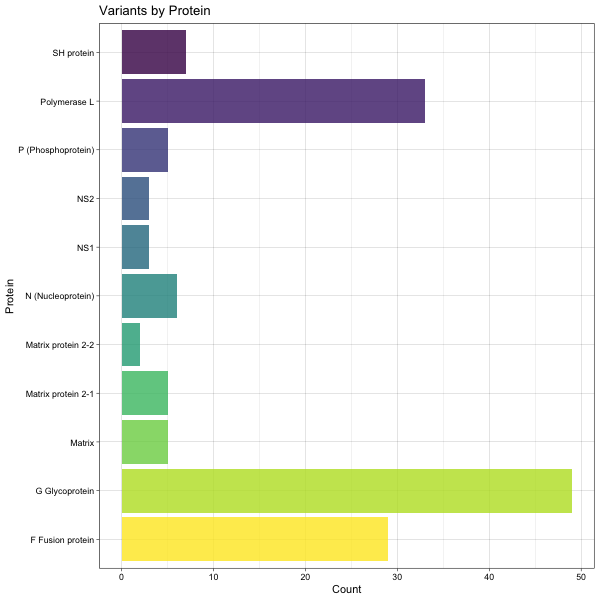

Temporary file deleted successfully.


In [77]:
# barplot of mutation frequencies
using RCall
using FileIO  # To handle image files in Julia
using Images  # Ensure you have this package

@rput variants  # Send the DataFrame to R environment

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

# Create the ggplot in R and save it as a PNG file
R"""
library(ggplot2)
library(viridis)
p <- ggplot(variants, aes(x = Protein, fill = Protein)) +
  geom_bar(stat = "count") +
  theme_linedraw() +
  theme(legend.position = "bottom") +
  labs(title = "Variants by Protein", x = "Protein", y = "Count") +
  scale_fill_viridis(discrete = TRUE, alpha = 0.8, direction = -1) +
  theme(legend.position = "none") +
  coord_flip()

png(filename = $output_path, width = 600, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
    img = load(output_path)
    display(img)

    # Delete the temporary image file after displaying
    rm(output_path; force = true)
    println("Temporary file deleted successfully.")
else
    println("File does not exist.")
end
